## Smoothing the Data using Kalman Filtering

Applies Kalman Filtering to the raw 297/58 town data as it was quite noisy. Took a few (too many) goes to get working, but finally does a good job. Have still kept the individual Kalman filtering in there just for reference.

In [2]:
# Import the many necessary libraries
import pandas as pd
import os
import numpy as np
import filterpy as fp
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import math
import networkx as nx
import time
import scipy

In [3]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from scipy.sparse import identity
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

First, create a dictionary where each entry is a dataframe of the adjacency matrix.

In [4]:
wa_297 = os.listdir("/Volumes/HardDrive/WA_297_big/")[:-1]

In [11]:
d = {}
for i in range(len(wa_297)-1):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/WA_297_big/"+wa_297[i], header = None, sep ='\t')

In [15]:
# Define some global variables
b = 58
big =58**2
weeks = 69

Create a list (allvals) which includes every value from every dataframe as one long list

In [16]:
allvals = []
for i in range(len(d.values())):
    l = d[str(i)].values.tolist()
    av = []
    for i in l:
        for k in i:
            av.append(k)
            allvals.append(k)

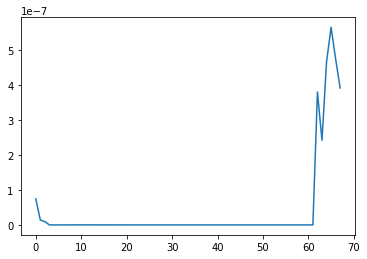

In [18]:
#Create a vector of all entries of a particular edge during all weeks from allvals
def timeseries_vector(x): 
    timeseries = []
    for i in range(weeks):
        timeseries.append(allvals[x+(big)*i])
    return timeseries
ts = timeseries_vector(7)
plt.plot(ts)

**Individual (edge by edge) Kalman Filter:**

This Kalman filter treats the time series of each edge as an individual entity and does a Kalman filter on that.

In [23]:
def kalman_gain(r,q, kalmans):
    # Kalman gain formula
    prev = kalmans[-1]
    kalmans.append( ((prev + q)**(-1)+1/r)**(-1) )
    return kalmans

In [24]:
mean = np.mean(allvals)
std = np.std(allvals)

In [25]:
def filtering(timeseries,r,q,mean,std):
    updated = [np.mean(timeseries)]
    inn = []
    kg = [((std**2 + q)**(-1) + 1/r)**(-1)]
    for t in timeseries:
        kg = kalman_gain(r,q,kg)
        
        # Updating of the data formula
        up = updated[-1] + kg[-1]*(r)**(-1)*(t - updated[-1])
        
        inn.append(t-updated[-1])
        updated.append(up)
        
    updated = updated[1:]
    return updated, kg, inn

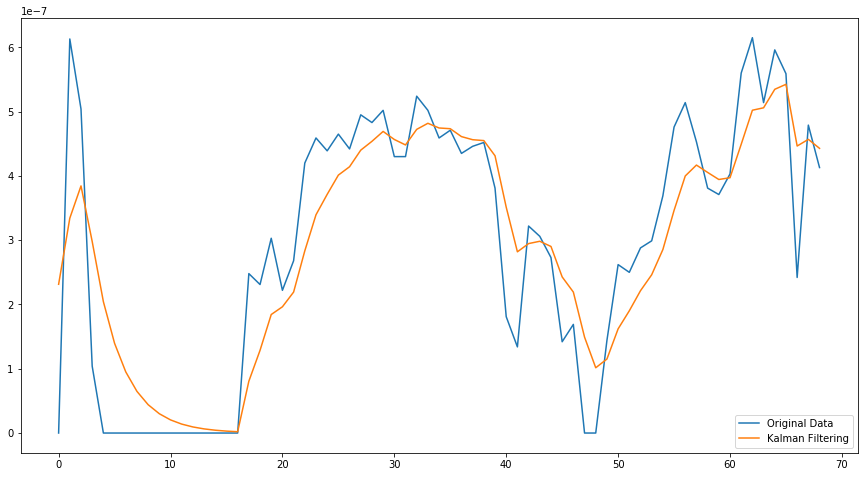

In [26]:
# E.g. just one edge
ts = timeseries_vector(7)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
f, kg, inn = filtering(ts, 2, 0.3, mean, std)
plt.plot(f, label = 'Kalman Filtering')
plt.legend()

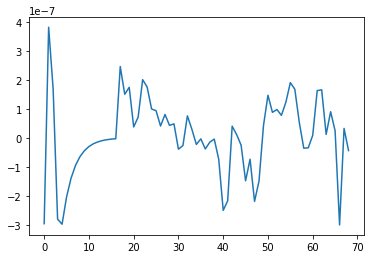

In [25]:
#Plot the innovations and make sure that they oscillate or at least don't converge.
plt.figure()
plt.plot(inn)

In [29]:
#Run a Kalman on each edge:
allkal = []
for i in range(big):
    ts = timeseries_vector(i)
    if all(0 == t for t in timeseries_vector(i) ): 
        #Check: if all 0's, just keep it as all 0's rather than a value that asymptotically approaches 0.
        f = [0]*weeks
    else:
        f, kg, inn = filtering(ts, 2, 0.3, mean, std)
    allkal.append(f)

In [31]:
# Rearrange the allkal so that it's in the adjacency matrix formation that it was before
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(allkal[i*b+k][j])
        n.append(nd)
    new_data.append(n)

In [34]:
# Write in to the file.
for j in range(69):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/kalman_individual_big/"+wa_297[j],sep = '\t',index = False, header = False)

**All to All Covariance**

Now it uses the Pearson Correlation between two edges as the intialisation of the all to all covariance matrix. Means edges actually have an effect on each other (but note it still approximates the individual case pretty well).

In [8]:
I = identity(big)

In [9]:
# Initialise the starting points
w = d['0'].copy()
for i in range(1,len(d.keys())):
    w += d[str(i)].copy()

# w is then the mean flow over all weeks
w = w/weeks
w.to_numpy()
w = w.values.tolist()
observ = []
for i in w:
    for j in i:
        observ.append(j)
# observ is a one big list representation of w

In [10]:
# Initialise the covariance matrix which we will later define elementwise.
R = lil_matrix((big,big))

In [11]:
# Iterate over all edges
for edge in range(big):
    print(edge)
    # Get the timeseries of each edge
    ts = timeseries_vector(edge)
    if np.all(np.array(ts)==0):
        continue
        # Ignore if it's just all 0s
    else:
        # Otherwise, get another edge
        for edgep in range(edge+1,big):
            tsp = timeseries_vector(edgep)
            if np.all(np.array(tsp)==0):
                continue
                # Again, ignore if it's all 0s
            else:
                # Otherwise compute the pearson correlation of the two timeseries and write it into R
                r = ((scipy.stats.pearsonr(ts,tsp))[0])**2
                if r > 0:
                    R[edge,edgep] = r
                    R[edgep,edge] = r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122


In [12]:
# The R matrix then becomes our initial Sig 
Sig = csc_matrix(R)

# We arbitrarily choose the diagonal value to be twice as large as the mean of R.
diag = 2*np.mean(Sig)
for edge in range(big):
    R[edge,edge] = diag
Sig = csc_matrix(R)

In [13]:
diag

0.0005693858239098234

In [14]:
Sig

<3364x3364 sparse matrix of type '<class 'numpy.float64'>'
	with 21996 stored elements in Compressed Sparse Column format>

In [16]:
def kalman_gain_all(r,q,kalman):
    # Define the kalman gain equation
    kg = inv(inv(kalman + q*I)+(1/r)*I)
    return kg

In [32]:
def filtering_all(r,q,cov,start):
    updated = [start] # First observations
    kg = cov # Sig
    inn = []
    # Iterate over all weeks
    for i in range(1,weeks):
        t = time.time()
        # Get the new Kalman gain
        kg = kalman_gain_all(r,q,kg)
        prev = updated[-1]
        gain = kg.dot((1/r)*I)
        vals = allvals[i*big:(i+1)*big] # Get the relevant week
        innov = csc_matrix(vals) - csc_matrix(prev)
        # Update the observation based on Kalman filtering
        up = np.transpose(csc_matrix(prev).toarray()) + gain.dot(np.transpose(innov.toarray()))
        upp = []
        for u in up:
            for j in u:
                if j < 0: # Ignore any below 0 entries as it's not physical
                    upp.append(0)
                else:
                    upp.append(j)
        updated.append(upp)
        e = time.time()
        print(i,e-t)
    #updated = updated[1:]
    return updated

In [33]:
up = filtering_all(diag*2,diag/5,Sig,observ) #Run the function!

1 2.243135929107666
2 2.2693161964416504
3 1.9502677917480469
4 1.9877989292144775
5 1.8984723091125488
6 1.9210820198059082
7 1.9324088096618652
8 1.8445029258728027
9 1.871912956237793
10 1.8620431423187256
11 1.8361358642578125
12 1.8459551334381104
13 1.8550307750701904
14 1.874622106552124
15 1.8672218322753906
16 1.8915510177612305
17 1.8679759502410889
18 1.8678820133209229
19 1.8743736743927002
20 1.8759047985076904
21 1.854546070098877
22 1.8737421035766602
23 1.8617839813232422
24 1.8674852848052979
25 1.8741819858551025
26 1.873533010482788
27 1.869969129562378
28 1.858262062072754
29 1.8446037769317627
30 1.8526978492736816
31 1.8725488185882568
32 1.8879551887512207
33 1.8570809364318848
34 1.8532531261444092
35 1.8641841411590576
36 1.8551108837127686
37 1.855522632598877
38 1.8589940071105957
39 1.8468260765075684
40 1.8599929809570312
41 1.8484070301055908
42 1.8531601428985596
43 1.8707101345062256
44 1.8618171215057373
45 1.8616869449615479
46 1.849602222442627
47 1.8

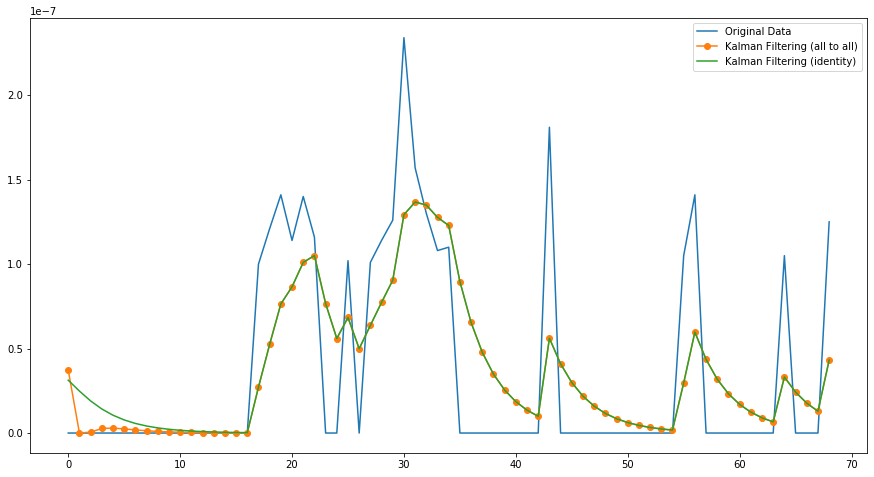

In [34]:
# Check some differenct edges and plot to see what you get!
v = 161
ts = timeseries_vector(v)
plt.figure(figsize = (15,8))
plt.plot(ts, label = 'Original Data')
fil = []
for i in range(weeks):
    fil.append(up[i][v])
plt.plot(fil, marker ='o',label = 'Kalman Filtering (all to all)')
f, kg, inn = filtering(ts, diag*2,diag/5, mean, std)
plt.plot(f, label = 'Kalman Filtering (identity)')
plt.legend()

In [35]:
# Check there are no negative entries remaining
for v in range(big):
    for i in range(weeks):
        if up[i][v] < 0:
            print(v,i, up[i][v])

In [36]:
# Rearrange data into the usable form, write it all into the files
new_data = []
for j in range(weeks):
    n = []
    for i in range(b):
        nd = []
        for k in range(b):
            nd.append(up[j][i*b+k])
        n.append(nd)
    new_data.append(n)

for j in range(weeks):
    df = pd.DataFrame(new_data[j])
    df.to_csv("/Volumes/HardDrive/kalman_all2all_big/"+wa_297[j],sep = '\t',index = False, header = False)

**Checking the sum of all edges every week:**

Text(0.5, 0, 'Week')

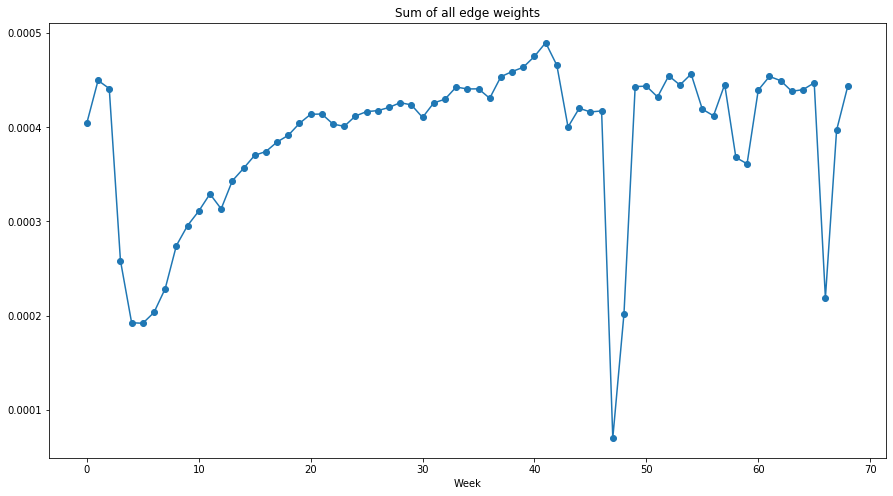

In [61]:
summ = []
for i in range(weeks):
    a = 0
    for j in d[str(i)].values.tolist():
        for k in j:
            a += k
    summ.append(a)
plt.figure(figsize = (15,8))
plt.plot(summ, marker = 'o')
plt.title('Sum of all edge weights')
plt.xlabel('Week')